# Previsão de Falha
### Instale dependências necessarias via:
```
pip instal requirements.txt
```

In [88]:
import logging
import warnings
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, roc_curve, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/full_devices.csv',encoding = "ISO-8859-1")
data

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


### Preliminares
Os dados sofrem de um forte desbalanceamento de classes (a classificação de falha é rara).

No geral, existem algumas estratégias para amenizar esse problema em problemas de classificação clássico:
* realizar reamostragem (_bootstrap_) afim de inflar a classe minoritária;
* realizar amostragem na classe majoritária, afim de diminuir sua incidência;
* geração de dados artificiais (SMOTE) para melhorar a diversidade da classe minoritária e aumentar seu volume;
* balanceamento por penalidade (inverso da frequência de cada classe);
* cruzamento de dados, onde se extrai dados de fontes externas para aumentar a cobertura da classe minoritária.

Dentre essas estratégias, julgamos a mais adequada a aplicação de SMOTE (uma vez que há uma raridade latente de falhas identificadas, possibilitando aumentar não só a cobertura como a variabilidade das informações dentro dessa classe).

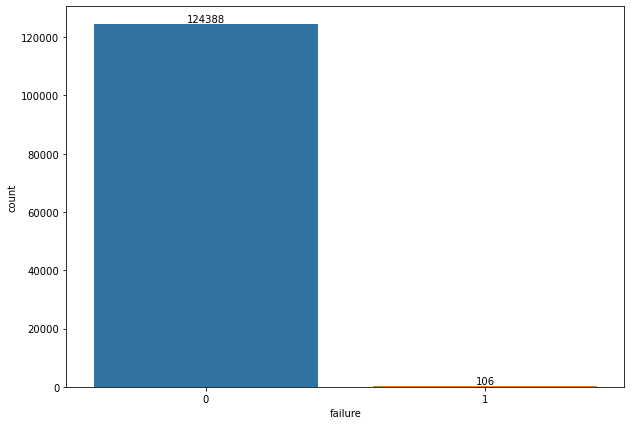

In [91]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10,7))
ax = sns.countplot(data=data, x='failure')
for container in ax.containers:
    ax.bar_label(container)

In [27]:
X_train, X_test, y_train, y_test = train_test_split((data.iloc[:,3:]-data.iloc[:,3:].mean())/data.iloc[:,3:].std(), data['failure'], test_size=0.35, random_state=42)

Devido ao desbalanceamento, optamos por ser ligeiramente mais severos quanto a regularização dos parâmetros estimados (explicando a motivação por C=0.6). 

Notamos que, via _k-fold_, conseguimos boas métricas de avaliação (em média), com baixa variação do seu valor. Dentre as métricas apresentadas, talvez a que se destaca mais pelo contexto do problema é a perda logarítmica.

Basicamente quanto menor, ou menos negativo no caso da perda logartimica negativa, esta métrica for, melhor será para avaliação do modelo. Isso ocorre porque estamos atribuindo uma maior probabilidade para cada acerto do modelo. Ao aplicarmos o log na probabilidade prevista pelo modelo, devido ao comportamento da função, probabilidades entre 0.5 e 1 gerarão _scores_ mais próximos de zero. Em contrapartida, se o modelo atribui uma baixa probabilidade a verdadeira classe da observação, a métrica apresentará um _score_ superior a |1|.

In [93]:
warnings.filterwarnings("ignore")

logistic_regression = LogisticRegression(penalty='l2', C=0.6, solver='newton-cholesky')
cv = RepeatedKFold(n_splits=15, n_repeats=3, random_state=42)

In [28]:
sm = SMOTE(random_state=42, sampling_strategy='minority')
X_smoted, y_smoted = sm.fit_resample(X_train, y_train)

In [97]:
accuracy_score = cross_val_score(logistic_regression, X_smoted, y_smoted, scoring='accuracy', cv=cv)
(np.mean(accuracy_score), np.std(accuracy_score))

(0.7566895026669987, 0.004738832596369492)

In [37]:
f1_score = cross_val_score(logistic_regression, X_smoted, y_smoted, scoring='f1', cv=cv)
(np.mean(f1_score), np.std(f1_score))

(0.6911520094802709, 0.006346699635791736)

In [38]:
roc_auc_score = cross_val_score(logistic_regression, X_smoted, y_smoted, scoring='roc_auc', cv=cv)
(np.mean(roc_auc_score), np.std(roc_auc_score))

(0.8616402651928519, 0.003748966630181712)

In [40]:
neg_log_loss_score = cross_val_score(logistic_regression, X_smoted, y_smoted, scoring='neg_log_loss', cv=cv)
(np.mean(neg_log_loss_score), np.std(neg_log_loss_score))

(-0.5077644700876286, 0.008156283711184677)

### Ajuste e Teste do modelo
Ao realizarmos a etapa de teste, percebemos uma piora dos _scores_ mais relevantes, f1 e perda logarítmica, enquanto os _scores_ de acurácia e da área sobre a curva podem ser desconsiderados, uma vez que em casos de desbalanceamento de classes ambos não se mostram muito úteis (um modelo que só classifica os dados pela classe majoritária já iriam conseguir bons _scores_ sobre ambas as métricas).

In [54]:
logistic_model = logistic_regression.fit(X_smoted, y_smoted)

In [64]:
y_classified = logistic_model.predict(X_test)
probability_predict = logistic_model.predict_proba(X_test)

In [78]:
metrics = pd.DataFrame({
    'metric':['accuracy', 'f1', 'roc_auc', 'log_loss'],
    'score':[accuracy_score(list(y_test), list(y_classified)), f1_score(list(y_test), list(y_classified), average='binary'), roc_auc_score(list(y_test), list(y_classified)), log_loss(list(y_test), list(y_classified))]
})

In [79]:
metrics

,metric,score
0,accuracy,0.969568
1,f1,0.022124
2,roc_auc,0.712252
3,log_loss,1.096869


A curva ROC, bem como a matriz de confundimento (ou confusão) evidenciam os pontos até então discutidos. Acertamos muito na classe '0', ou "não falha", (o que era de se esperar), enquanto na classe '1', de "falha", tivemos uma classificação similar a jogar uma moeda.

In [ ]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

Text(0, 0.5, 'True Positive Rate')

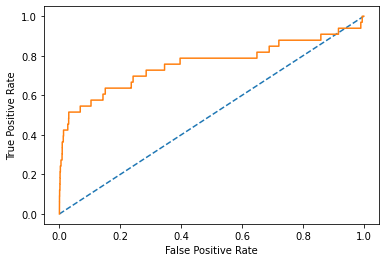

In [87]:
lr_probs = probability_predict[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, np.zeros(len(y_test)))
lr_fpr, lr_tpr, _ = roc_curve(y_test, probability_predict[:, 1])

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0.5, 1.0, 'Matriz de Confusão')

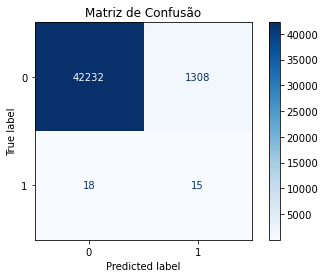

In [90]:
disp = ConfusionMatrixDisplay.from_estimator(
        logistic_model,
        X_test,
        y_test,
        display_labels=logistic_model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Matriz de Confusão')

In [100]:
print(f"Custo total gerado pelos erros (falsos positivos e flasos negativos): {1308*0.5 + 18}")

Custo total gerado pelos erros (falsos positivos e flasos negativos): 672.0


In [67]:
results = pd.DataFrame({
    'class':list(y_classified),
    'prob_0':list(probability_predict.T[0]),
    'prob_1':list(probability_predict.T[1])
})

In [68]:
results

,class,prob_0,prob_1
0,0,0.848273,0.151727
1,0,0.574951,0.425049
2,0,0.696707,0.303293
3,0,0.661730,0.338270
4,0,0.646987,0.353013
...,...,...,...
43568,1,0.458662,0.541338
43569,0,0.670988,0.329012
43570,0,0.627957,0.372043
43571,0,0.631763,0.368237


## Discussões Finais e Proposta

A aplicação de modelos clássicos de classificação em processos de controle como o do problema, quase sempre é ineficiente. Notamos que a dimensão de tempo, disponível nos dados, é ignorada pelos modelos clássicos de classificação, o que é pouco interessante quando desejamos prever a degeneração de um elemento/dispositivo/máquina/processo de produção.

Como tentei fazer algo dentro de um tempo hábil, deixo a minha sugestão para caso gozasse de maior tempo para solução do problema:

* A fim de incorporar a dimensão de tempo a modelagem, podemos desenvolver modelos de séries temporais, comuns em Controle Estatístico de Processos (CEP). Tais modelos são mais adequados quando precisamos "prever" uma desconformidade rara no processo (entenda processo por falha no dispositivo). Além disso, modelos de séries temporais dificilmente são descontinuados por não precisarem de "retreino".
* Baseado na priori de que cada um dos processos (ou dispositivos) são multualmente independentes, torna-se desejavel desenvolver um modelo de série temporal para cada (dado que o número dos dispositivos não tenda a crescer).
* Modelos de séries temporais, apesar de exigirem mais complexidade, nos proporcionam não só a previsão da probabilidade de falha mais adequada, quanto nos permite indexá-lo em cartas de controle que automatizam a atuação em reparos de eventuais dispositivos.